Prepare maps for analysis
- convert to z map
- check MNI space

Hypotheses:

Parametric effect of gain:

1. Positive effect in ventromedial PFC - for the equal indifference group
2. Positive effect in ventromedial PFC - for the equal range group
3. Positive effect in ventral striatum - for the equal indifference group
4. Positive effect in ventral striatum - for the equal range group

Parametric effect of loss:
- 5: Negative effect in VMPFC - for the equal indifference group
- 6: Negative effect in VMPFC - for the equal range group
- 7: Positive effect in amygdala - for the equal indifference group
- 8: Positive effect in amygdala - for the equal range group

Equal range vs. equal indifference:

- 9: Greater positive response to losses in amygdala for equal range condition vs. equal indifference condition.


In [7]:
import numpy,pandas
import nibabel
import json
import os,glob
import nilearn.image
import nilearn.input_data
import nilearn.plotting
from collections import OrderedDict,Counter
import shutil
import warnings
import sklearn
import matplotlib.pyplot as plt
import seaborn
import scipy.cluster
from sklearn.cluster import AgglomerativeClustering


%matplotlib inline

hypotheses= {1:'+gain: equal indiff',
            2:'+gain: equal range',
            3:'+gain: equal indiff',
            4:'+gain: equal range',
            5:'-loss: equal indiff',
            6:'-loss: equal range',
            7:'+loss: equal indiff',
            8:'+loss: equal range',
            9:'+loss:ER>EI'}

# we don't neet work with 3 and 4 because maps are the same as 2 and 3, just different regions of interest
hypnums = [1,2,5,6,7,8,9]

# create some variables used throughout
orig_dir = '/Users/poldrack/data_unsynced/NARPS/maps/orig'
output_dir = '/Users/poldrack/data_unsynced/NARPS/maps'
figure_dir = os.path.join(output_dir,'figures')
template_img = os.path.join(output_dir,'templates/MNI152_T1_2mm.nii.gz')
mask_img = os.path.join(output_dir,'templates/MNI152_T1_2mm_brain_mask.nii.gz')

cut_coords = [-24,-10,4,18,32,52,64]


### loading the metadata


In [8]:
metadata_file = '/Users/poldrack/data_unsynced/NARPS/analysis_pipelines_SW.xlsx'
metadata = pandas.read_excel(metadata_file,header=1)
metadata.shape
metadata.index = metadata.teamID

    

In [9]:
# create dictionary mapping from teamID to collection ID
teamid_to_collectionID_dict={}
for i in metadata.index:
    teamid_to_collectionID_dict[i]='_'.join([metadata.loc[i,'NV_collection_string'],i])


In [10]:
metadata.columns

Index(['teamID', 'NV_collection_string', 'results_comments', 'preregistered',
       'link_preregistration_form', 'regions_definition', 'softwares', 'SW',
       'Unnamed: 8', 'n_participants', 'exclusions_details',
       'used_fmriprep_data', 'preprocessing_order', 'brain_extraction',
       'segmentation', 'slice_time_correction', 'motion_correction',
       'gradient_distortion_correction', 'intra_subject_coreg',
       'distortion_correction', 'inter_subject_reg', 'intensity_correction',
       'intensity_normalization', 'noise_removal', 'volume_censoring',
       'spatial_smoothing', 'preprocessing_comments',
       'data_submitted_to_model', 'spatial_region_modeled',
       'independent_vars_first_level', 'independent_vars_higher_level',
       'model_type', 'model_settings', 'inference_contrast_effect',
       'search_region', 'statistic_type', 'pval_computation',
       'multiple_testing_correction', 'comments_analysis', 'general comments',
       'additional files?'],
      d

In [11]:
Counter(metadata.SW)

Counter({'FSL': 19,
         nan: 2,
         'SPM': 4,
         'nistats': 3,
         'randomise': 5,
         'AFNI': 9,
         'SPM12': 20,
         'Other': 2,
         'SVC': 2,
         'SPM8': 1,
         'PALM': 2,
         'SPM5': 1})

### Processing the statistical images

#### Overlap maps for thresholded images

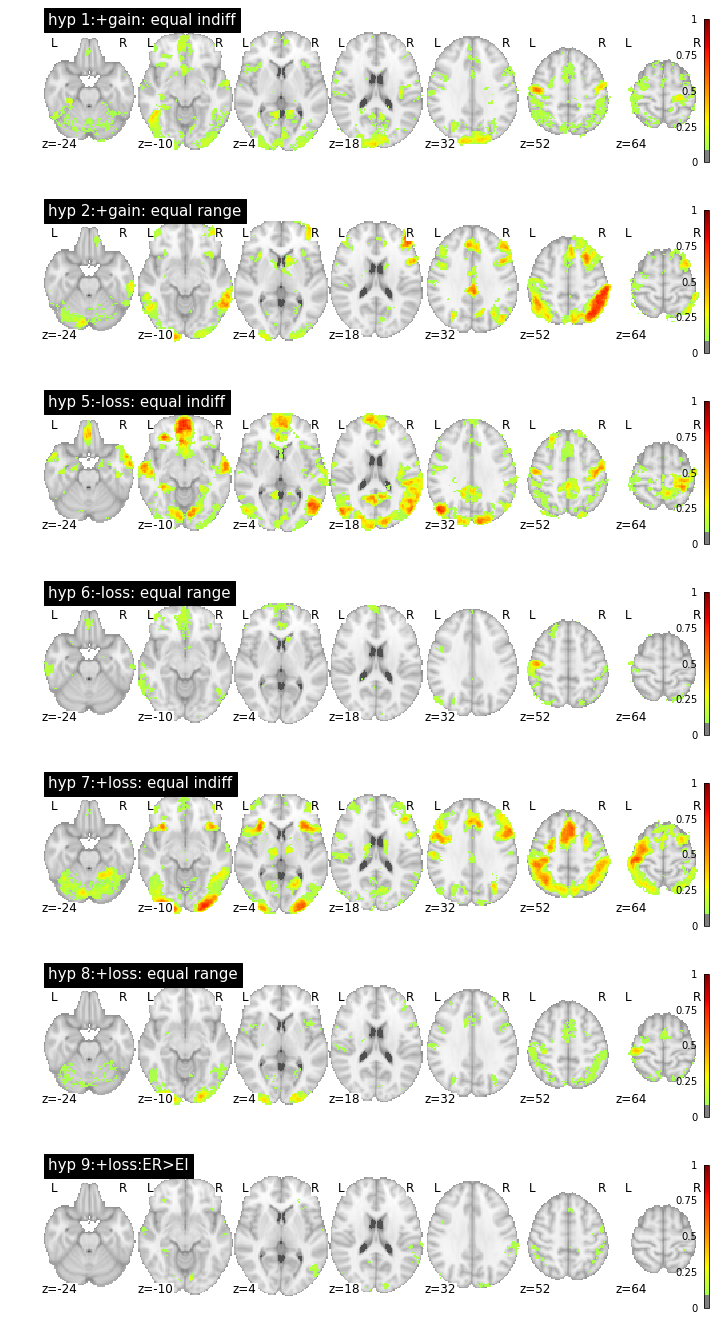

In [12]:
# display overlap maps for thresholded maps


fig, ax = plt.subplots(7,1,figsize=(12,24))
for i,hyp in enumerate(hypnums):
    img=os.path.join(output_dir,'thresh_mean/hypo%d.nii.gz'%hyp)
    nilearn.plotting.plot_stat_map(img, threshold=0.1, display_mode="z", 
                colorbar=True,title='hyp %d:'%hyp+hypotheses[hyp],vmax=1.,cmap='jet',
                                  cut_coords = cut_coords,axes = ax[i])
plt.savefig(os.path.join(figure_dir,'overlap_map.pdf'))


#### Range and variance maps

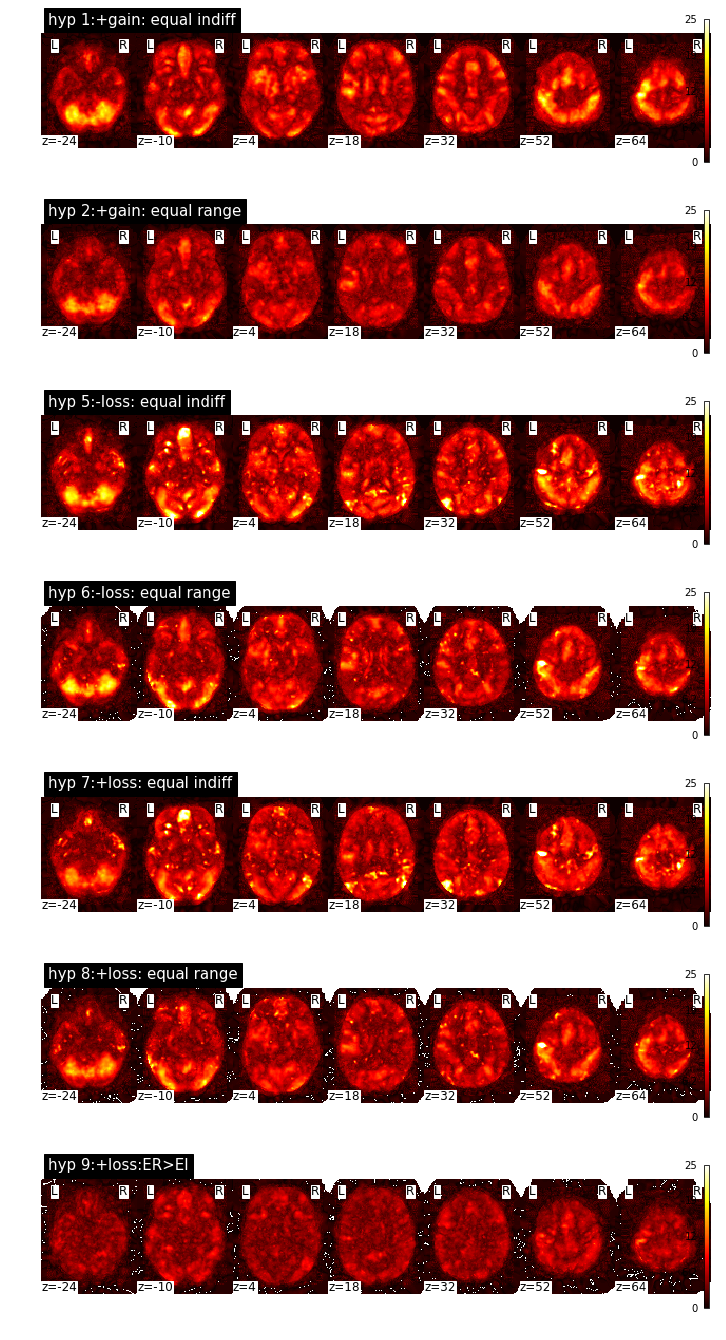

In [13]:
# show range maps
#fig = plt.fig
fig, ax = plt.subplots(7,1,figsize=(12,24))
for i,hyp in enumerate(hypnums):
    range_img=nibabel.load(os.path.join(output_dir,'unthresh_range/hypo%d.nii.gz'%hyp))
    nilearn.plotting.plot_stat_map(range_img, threshold=.1, display_mode="z", 
                           colorbar=True,title='hyp %d:'%hyp+hypotheses[hyp],vmax=25,
                                  cut_coords = cut_coords,axes = ax[i])
plt.savefig(os.path.join(figure_dir,'range_map.pdf'))

In [ ]:
# show std maps
fig, ax = plt.subplots(7,1,figsize=(12,24))
for i,hyp in enumerate(hypnums):
    std_img=nibabel.load(os.path.join(output_dir,'unthresh_std/hypo%d.nii.gz'%hyp))
    nilearn.plotting.plot_stat_map(std_img, threshold=.1, display_mode="z", 
                           colorbar=True,title='hyp %d:'%hyp+hypotheses[hyp],vmax=4,
                                   cut_coords = cut_coords,axes = ax[i])
plt.savefig(os.path.join(figure_dir,'std_map.pdf'))

#### Display unthresholded maps 

In [ ]:
imgtype='unthresh'
imginfo = {}
plot_data=True
use_fmriprep_only=False
show_md = False
nnz = []
nonzero_volume = []

dim_values = []
missing_metadata = []


for hyp in hypnums:
    hmaps = glob.glob(os.path.join(output_dir,'rectified/*/hypo%d_unthresh.nii.gz'%hyp))
    fig, ax = plt.subplots(len(hmaps),1,figsize=(12,180))
    print('making figure for hypothesis',hyp)
    # load all maps and get dims
    for i,m in enumerate(hmaps):
        img = nibabel.load(m)
        collection = m.split('/')[-2]
        collection_string,teamID = collection.split('_')
        dims = img.header.get_data_shape()
        dim_values.append(dims)
        
        md = metadata.query('NV_collection_string == "%s"'%collection_string).replace(numpy.nan,'na')
        if md.shape[0]==0:
            # try other identifier
            md = metadata.query('teamID == "%s"'%teamID)
            if md.shape[0]==0:
                missing_metadata.append(collection)
                continue
        if use_fmriprep_only:
            if not md['used_fmriprep_data'].values[0].find('Yes')>-1:
                continue
        qform = img.header.get_qform()
        #print(m)
        #print()
        #print(qform)
        # check for thresholding
        imgdata=img.get_data()
        nonzero_vox = numpy.nonzero(imgdata)
        n_nonzero_vox = len(nonzero_vox[0])
        nnz.append(n_nonzero_vox)
        vox_vol = numpy.prod(dims)
        nonzero_volume.append(n_nonzero_vox*vox_vol)
        #print(collection,dims, numpy.prod(dims),n_nonzero_vox*vox_vol)
        if show_md:
            print(md['inter_subject_reg'].values)
        if plot_data:
            if md['used_fmriprep_data'].values[0].find('Yes')>-1:
                prep_string = 'fmriprep'
            else:
                prep_string = 'other'
            nilearn.plotting.plot_stat_map(img, threshold=2., display_mode="z", 
                           colorbar=True,title='_'.join([collection,md['SW'].values[0],prep_string]),
                                          cut_coords = cut_coords,axes=ax[i])
    if plot_data:
        plt.savefig(os.path.join(figure_dir,'hyp%d_individual_maps.pdf'%hyp))


making figure for hypothesis 1


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


making figure for hypothesis 2


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


making figure for hypothesis 5


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


#### Dimensionality reduction

In [ ]:
# load all images for hypothesis 1 and perform tsne

def get_masked_data(hyp,mask_img,imgtype='unthresh'):
    if imgtype == 'unthresh':
        hmaps = glob.glob(os.path.join(output_dir,'rectified/*/hypo%d_unthresh.nii.gz'%hyp))
    elif imgtype == 'thresh':
        hmaps = glob.glob(os.path.join(output_dir,'rectified/*/hypo%d_thresh.nii.gz'%hyp))
    else:
        raise Exception('bad imgtype argument')
       
    #combined_data = nilearn.image.concat_imgs(hmaps)
    masker = nilearn.input_data.NiftiMasker(mask_img=mask_img)
    maskdata=masker.fit_transform(hmaps) #combined_data)   
    maskdata = numpy.nan_to_num(maskdata)
    if imgtype=='thresh':
        maskdata = (maskdata>1e-4).astype('float')
    labels = [os.path.basename(os.path.dirname(i)).split('_')[1] for i in hmaps]
    return(maskdata,labels)
    

In [ ]:
def run_dimensionality_reduction(maskdata):
    tsne = sklearn.manifold.TSNE()
    tsne_fit = tsne.fit_transform(maskdata)
    mds = sklearn.manifold.MDS()
    mds_fit = mds.fit_transform(maskdata)
    returm(tsne_fit,mds_fit)

In [ ]:
#plt.scatter(tsne_fit[:,0],tsne_fit[:,1])

In [ ]:
#plt.scatter(mds_fit[:,0],mds_fit[:,1])

#### Correlation maps for unthresholded images

In [ ]:
dendrograms = {}
cc_unthresh={}
for i,hyp in enumerate(hypnums):
    maskdata,labels = get_masked_data(hyp,mask_img)        
    cc = numpy.corrcoef(maskdata)
    cc = numpy.nan_to_num(cc)
    df = pandas.DataFrame(cc,index=labels,columns=labels)
    cm = seaborn.clustermap(df,cmap='jet',figsize=(16,16),method='ward')
    plt.title('hyp %d:'%hyp+hypotheses[hyp])
    cc_unthresh[hyp]=(cc,labels)
    plt.savefig(os.path.join(figure_dir,'hyp%d_correlation_map_unthresh.pdf'%hyp))
    dendrograms[hyp]=cm.dendrogram_row.linkage
    
    

### Clustering of unthresholded images


In [ ]:
# use clustering from seaborn to separate the different clusters into images
n_clusters=4

#for i,hyp in enumerate(hypnums):
i=0
hyp=1
if 1:
    clustlabels = scipy.cluster.hierarchy.cut_tree(dendrograms[hyp],n_clusters=n_clusters)
    membership={}
    for i in cm.dendrogram_row.reordered_ind:
        cl=clustlabels[i][0]
        if not cl in membership:
            membership[cl]=[]
        membership[cl].append(labels[i])
        
    for cl in membership:
        # get all images for this cluster and average them
        member_maps = []
        for member in membership[cl]
            cid = teamid_to_collectionID_dict[member]
            unthresh_map
            
        
        

In [ ]:
membership

In [ ]:
maskdata,labels = get_masked_data(1,mask_img)    
maskdata.shape

In [ ]:

for c in numpy.unique(clust.labels_):
    print('cluster',c)
    print([labels[i] for i in range(len(labels)) if clust.labels_[i]==c])

In [ ]:
labels

#### Similarity maps for thresholded images (Jaccard)

In [ ]:
def matrix_jaccard(mtx):
    jacmtx = numpy.zeros((mtx.shape[0],mtx.shape[0]))
    for i in range(mtx.shape[0]):
        for j in range(i+1,mtx.shape[0]):
            if i==j:
                 continue
            if numpy.sum(mtx[i,:])>0 and numpy.sum(mtx[j,:])>0:
                jacmtx[i,j]=sklearn.metrics.jaccard_score(mtx[i,:],mtx[j,:]) 
    
    jacmtx = numpy.nan_to_num(jacmtx)
    jacmtx = jacmtx + jacmtx.T
    jacmtx[numpy.diag_indices_from(jacmtx)]=1
    return(jacmtx)



In [ ]:
n_active = pandas.DataFrame(columns=['hyp','p_active','team'])
for hyp in [1,2,5,6,7,8,9]:
    maskdata,labels = get_masked_data(hyp,mask_img,imgtype='thresh')
    tmp = pandas.DataFrame({'n_active':numpy.sum(maskdata,1),
                            'hyp':(numpy.ones(maskdata.shape[0])*hyp).astype('int'),
                           'team':labels})
    n_active = pandas.concat((n_active,tmp))
    


In [ ]:
seaborn.boxplot(x="hyp", y="n_active", data=n_active)
plt.savefig(os.path.join(figure_dir,'n_active_voxels.pdf'))

In [ ]:
# get jaccard comparisons

cc_thresh={}
get_jaccard = False
for hyp in [1,2,5,6,7,8,9]:
    maskdata,labels = get_masked_data(hyp,mask_img,imgtype='thresh')
    cc = matrix_jaccard(maskdata)
    df = pandas.DataFrame(cc,index=labels,columns=labels)
    cc_thresh[hyp]=df


In [ ]:
for hyp in [1,2,5,6,7,8,9]:
    df = cc_thresh[hyp]
    seaborn.clustermap(df,cmap='jet',figsize=(16,16),method='ward')
    plt.title(hypotheses[hyp])
    plt.savefig(os.path.join(figure_dir,'hyp%d_jaccard_map_thresh.pdf'%hyp))

In [ ]:
# how is it that VMPFC agreement is so good for negative loss but not for positive gain?


In [ ]:
# compute map similarity for fmriprep studies versus others


for hyp in [1,2,5,6,7,8,9]:
    cc,labels = cc_unthresh[hyp]
    md = metadata.reindex(labels)
    fmriprep_used = md['used_fmriprep_data']=='Yes'
    cc_fmriprep = cc[fmriprep_used,:]
    cc_fmriprep = cc_fmriprep[:,fmriprep_used]
    cc_other = cc[~fmriprep_used,:]
    cc_other = cc_other[:,~fmriprep_used]
    
    fmriprep_mean_sim = numpy.mean(cc_fmriprep[numpy.triu_indices_from(cc_fmriprep)])
    other_mean_sim = numpy.mean(cc_other[numpy.triu_indices_from(cc_other)])
    print(hypotheses[hyp])
    print('fmriprep mean similarity:',fmriprep_mean_sim)
    print('other mean similarity:',other_mean_sim)
    print('')

In [ ]:
for hyp in [1,2,5,6,7,8,9]:
    cc,labels = cc_unthresh[hyp]
    md = metadata.reindex(labels)
    cc_fsl = cc[md['SW']=='FSL',:]
    cc_fsl = cc_fsl[:,md['SW']=='FSL']
    cc_spm12 = cc[md['SW']=='SPM12',:]
    cc_spm12 = cc_spm12[:,md['SW']=='SPM12']
    cc_bw = cc[md['SW']=='SPM12',:]
    cc_bw = cc_spm12[:,md['SW']=='SPM12']
    
    fsl_mean_sim = numpy.mean(cc_fsl[numpy.triu_indices_from(cc_fsl)])
    spm12_mean_sim = numpy.mean(cc_spm12[numpy.triu_indices_from(cc_spm12)])
    print(hypotheses[hyp])
    print('fsl mean similarity:',fsl_mean_sim)
    print('spm12 mean similarity:',spm12_mean_sim)
    print('')

In [ ]:
### compare image similarity to mean in relation to confidence of team
